## Dataset Paper
https://web.cs.hacettepe.edu.tr/~selman/malevis/

In [34]:
# Imports
import tensorflow as tf
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report
# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

In [71]:
# Walk the dataset folder, move all images not in "Other" folder into ../binary_dataset/malware folder
# Move all images in "Other" folder into ../binary_dataset/benign folder

import os
import shutil

def setup_binary_dataset():
    # Check to see if binary_dataset folder exists, if not create it
    if not os.path.exists("binary_dataset"):
        os.makedirs("binary_dataset")
        os.makedirs("binary_dataset/train")
        os.makedirs("binary_dataset/train/benign")
        os.makedirs("binary_dataset/train/malware")
        os.makedirs("binary_dataset/test")
        os.makedirs("binary_dataset/test/benign")
        os.makedirs("binary_dataset/test/malware")

    # Walk the dataset folder
    for root, dirs, files in os.walk("dataset/train/"):
        for name in files:
            if name.endswith(".png"):
                # If the image is in "Other" folder, move it to benign folder
                if root.endswith("Other"):
                    shutil.move(os.path.join(root, name), os.path.join("binary_dataset/train/benign", name))
                # If the image is not in "Other" folder, move it to malware folder
                else:
                    shutil.move(os.path.join(root, name), os.path.join("binary_dataset/train/malware", name))

    for root, dirs, files in os.walk("dataset/val/"):
        for name in files:
            if name.endswith(".png"):
                # If the image is in "Other" folder, move it to benign folder
                if root.endswith("Other"):
                    shutil.move(os.path.join(root, name), os.path.join("binary_dataset/test/benign", name))
                # If the image is not in "Other" folder, move it to malware folder
                else:
                    shutil.move(os.path.join(root, name), os.path.join("binary_dataset/test/malware", name))
    # Remove the empty folders
    os.rmdir("dataset/")

# Plot the training and validation accuracy and loss at each epoch
# https://www.tensorflow.org/tutorials/images/classification#visualize_training_results
def plot_train_val_accuracy(history, epochs):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()


In [36]:
def get_train_val_dataset():
    train_ds = tf.keras.preprocessing.image_dataset_from_directory(
        "./dataset/train/",
        seed=123,
        labels="inferred",
        label_mode="binary",
        shuffle=True,
        image_size=(300, 300),
        validation_split=0.2,
        subset="training",
    )

    val_ds = tf.keras.preprocessing.image_dataset_from_directory(
        "./dataset/train/",
        seed=123,
        labels="inferred",
        label_mode="binary",
        shuffle=True,
        image_size=(300, 300),
        validation_split=0.2,
        subset="validation", 
    )

    return train_ds, val_ds

def get_test_dataset():
    test_ds = tf.keras.preprocessing.image_dataset_from_directory(
        "dataset/test",
        seed=123,
        labels="inferred",
        label_mode="binary",
        shuffle=False,
        image_size=(300, 300),
    )

    return test_ds

train_ds, val_ds = get_train_val_dataset()
class_names = train_ds.class_names


Found 9100 files belonging to 2 classes.
Using 7280 files for training.
Found 9100 files belonging to 2 classes.
Using 1820 files for validation.


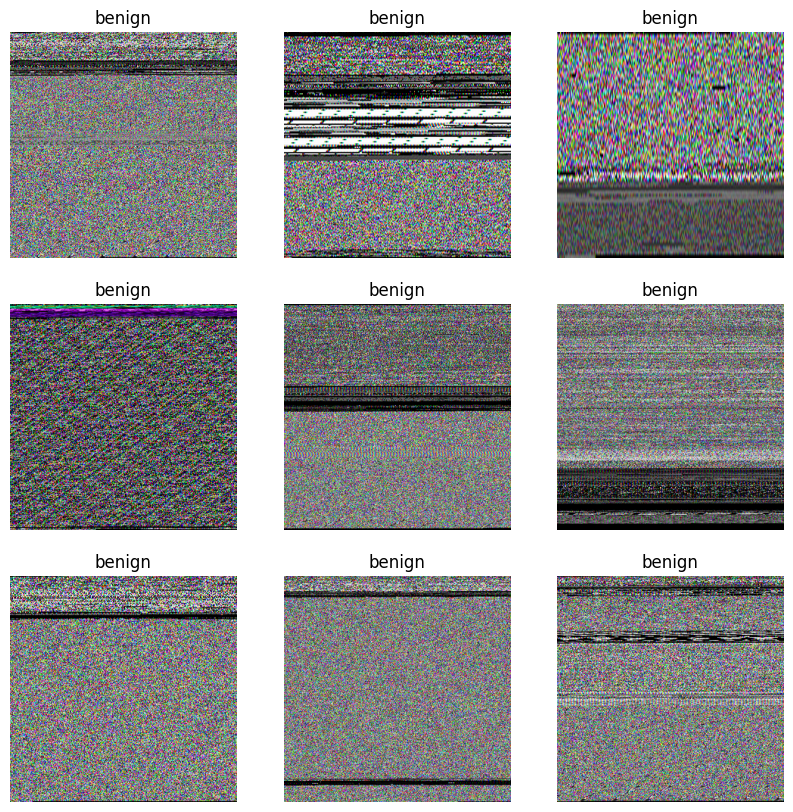

In [57]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[np.argmax(labels[i])])
    plt.axis("off")


In [75]:
def get_true_labels(test_ds):
    true_labels = []

    for _, labels in test_ds:
        for label in labels:
            true_labels.append(label.numpy()[0])

    return true_labels

def print_classification_report(true_labels, predictions, class_names):
    print(classification_report(true_labels, predictions, target_names=class_names))

def plot_confusion_matrix(true_labels, predictions):
    matrix = tf.math.confusion_matrix(
        true_labels, predictions, num_classes=2, weights=None, dtype=tf.dtypes.int32, name=None
    )

    # Plot the confusion matrix


    plt.figure(figsize=(10, 10))
    sns.heatmap(matrix, annot=True, fmt='g')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

def report(predictions, test_ds):
    true_labels = get_true_labels(test_ds)
    # Get the predicted class with the highest probability for each sample
    preds = [i.round() for i in predictions]

    print_classification_report(true_labels, preds, class_names)
    plot_confusion_matrix(true_labels, preds)

In [174]:
num_classes = len(class_names)


model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255, input_shape=(300, 300, 3)),
  tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid')
])



In [175]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.BinaryCrossentropy(),
  metrics=['accuracy']
)


In [176]:
model.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_15 (Rescaling)    (None, 300, 300, 3)       0         
                                                                 
 conv2d_97 (Conv2D)          (None, 300, 300, 16)      448       
                                                                 
 max_pooling2d_103 (MaxPool  (None, 150, 150, 16)      0         
 ing2D)                                                          
                                                                 
 conv2d_98 (Conv2D)          (None, 150, 150, 32)      4640      
                                                                 
 max_pooling2d_104 (MaxPool  (None, 75, 75, 32)        0         
 ing2D)                                                          
                                                                 
 dropout_25 (Dropout)        (None, 75, 75, 32)      

In [177]:
epochs = 3
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)


Epoch 1/3
228/228 [==============================] - 76s 331ms/step - loss: 0.2399 - accuracy: 0.9615 - val_loss: 0.1047 - val_accuracy: 0.9665
Epoch 2/3
228/228 [==============================] - 76s 331ms/step - loss: 0.0875 - accuracy: 0.9717 - val_loss: 0.0753 - val_accuracy: 0.9824
Epoch 3/3
228/228 [==============================] - 76s 334ms/step - loss: 0.0557 - accuracy: 0.9843 - val_loss: 0.0757 - val_accuracy: 0.9841


In [66]:
plot_train_val_accuracy(history, epochs)

ValueError: Number of rows must be a positive integer, not 0

<Figure size 800x800 with 0 Axes>

In [182]:
test_ds = get_test_dataset()
# Evaluate the model on the test data using `evaluate`
eval_res = model.evaluate(test_ds, verbose=2)

eval_res

Found 5126 files belonging to 2 classes.
161/161 - 14s - loss: 0.7899 - accuracy: 0.8221 - 14s/epoch - 85ms/step


[0.7898768186569214, 0.8220834732055664]

## Making Predictions

In [179]:
# Get the test data. Ensure that the dataset is not shuffled. Enabling shuffling will cause the predictions to be out of order.
# Since the dataset is shuffled after every epoch, the predictions will be different every time the model is evaluated.
# https://stackoverflow.com/questions/71706820/tensorflow-dataset-order-appears-randomised-when-iterating-via-for-loop?rq=3
test_ds = get_test_dataset()

predictions = model.predict(test_ds)

Found 5126 files belonging to 2 classes.
161/161 [==============================] - 14s 85ms/step


In [180]:
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(predictions[0])], 100 * np.max(predictions[0]))
)


0.8749572
0
This image most likely belongs to benign with a 87.50 percent confidence.
{1: 4520, 0: 606}
{1: 3644, 0: 1482}


              precision    recall  f1-score   support

      benign       0.97      0.40      0.56      1482
     malware       0.80      1.00      0.89      3644

    accuracy                           0.82      5126
   macro avg       0.89      0.70      0.73      5126
weighted avg       0.85      0.82      0.79      5126



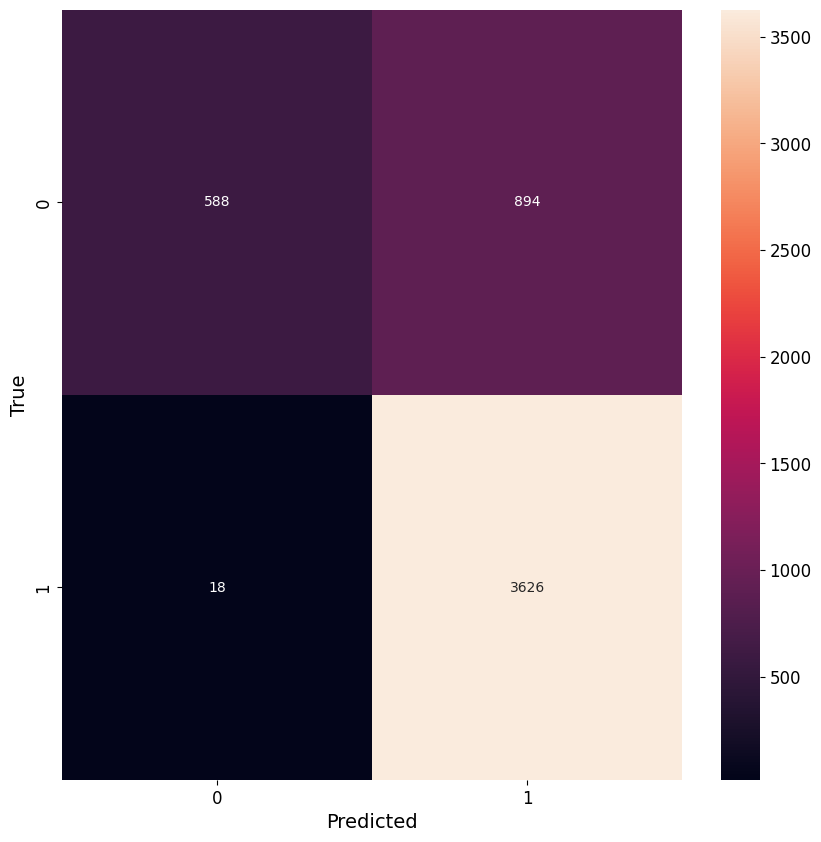

In [181]:
report(predictions, test_ds)

## Model 2

In [37]:
train_ds, val_ds = get_train_val_dataset()

Found 9100 files belonging to 2 classes.
Using 7280 files for training.
Found 9100 files belonging to 2 classes.
Using 1820 files for validation.


In [38]:
resnet_model = tf.keras.Sequential()

pretrained_model = tf.keras.applications.ResNet50(include_top=False, input_shape=(300, 300, 3), pooling='avg', weights='imagenet', classes=2)

for layer in pretrained_model.layers:
    layer.trainable = False

resnet_model.add(pretrained_model)
resnet_model.add(tf.keras.layers.Flatten())
resnet_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [39]:
resnet_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_4 (Flatten)         (None, 2048)              0         
                                                                 
 dense_5 (Dense)             (None, 1)                 2049      
                                                                 
Total params: 23589761 (89.99 MB)
Trainable params: 2049 (8.00 KB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


In [40]:
resnet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [41]:
epochs = 3
history = resnet_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/3
228/228 [==============================] - 523s 2s/step - loss: 0.1226 - accuracy: 0.9650 - val_loss: 0.0890 - val_accuracy: 0.9681
Epoch 2/3
228/228 [==============================] - 515s 2s/step - loss: 0.0710 - accuracy: 0.9765 - val_loss: 0.0691 - val_accuracy: 0.9808
Epoch 3/3
228/228 [==============================] - 515s 2s/step - loss: 0.0573 - accuracy: 0.9808 - val_loss: 0.0619 - val_accuracy: 0.9813


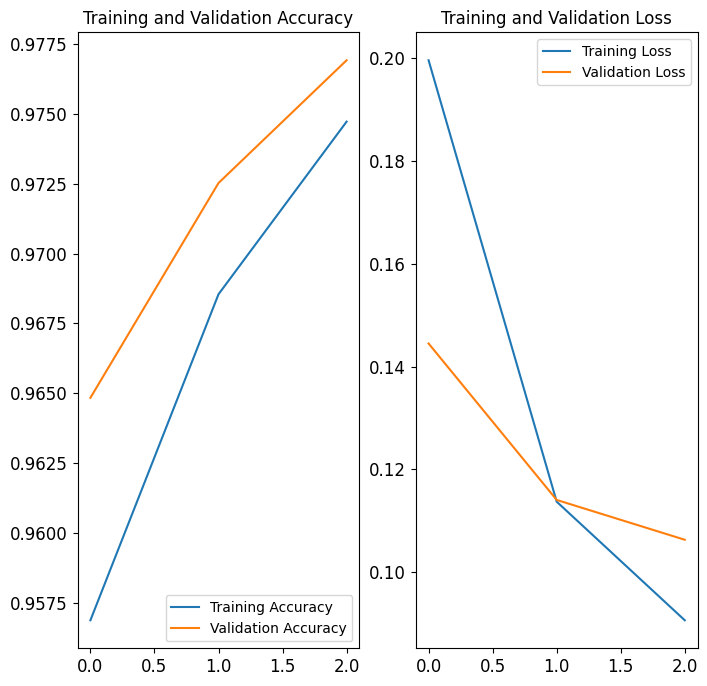

In [72]:
plot_train_val_accuracy(history, epochs)


In [45]:
test_ds = get_test_dataset()
# Evaluate the model on the test data using `evaluate`
eval_res = resnet_model.evaluate(test_ds, verbose=2)

eval_res

Found 5126 files belonging to 2 classes.
161/161 - 288s - loss: 0.7669 - accuracy: 0.8398 - 288s/epoch - 2s/step


[0.7669379115104675, 0.8398361206054688]

In [47]:
test_ds = get_test_dataset()
predictions = resnet_model.predict(test_ds)

Found 5126 files belonging to 2 classes.
161/161 [==============================] - 292s 2s/step


              precision    recall  f1-score   support

      benign       0.98      0.46      0.62      1482
     malware       0.82      1.00      0.90      3644

    accuracy                           0.84      5126
   macro avg       0.90      0.73      0.76      5126
weighted avg       0.86      0.84      0.82      5126



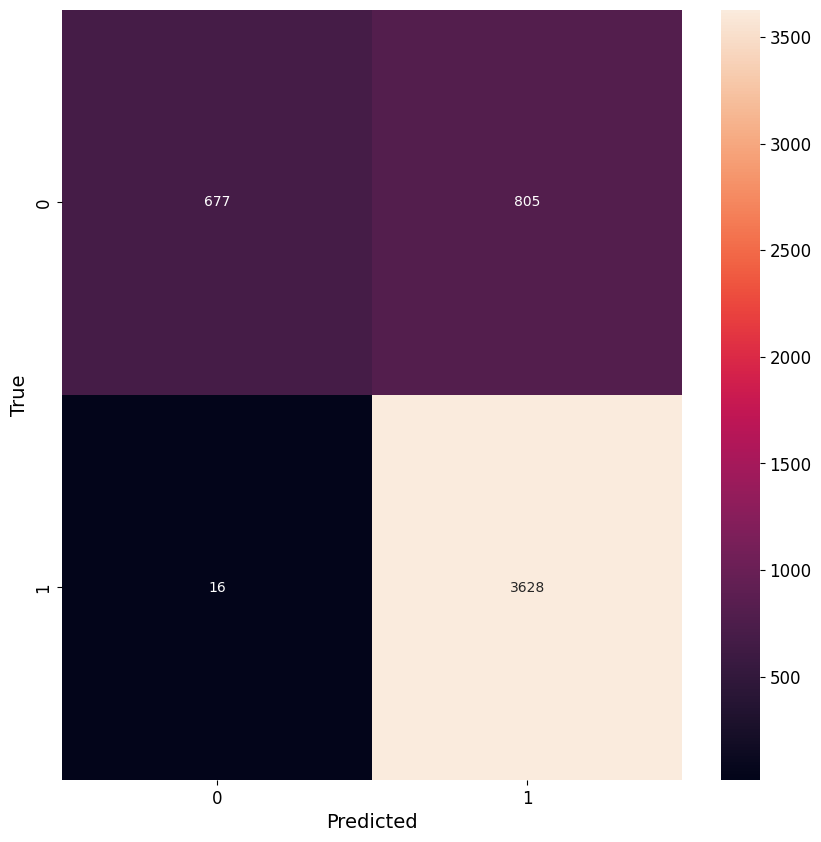

In [48]:
report(predictions, test_ds)

## Use VGG16 Model 

In [51]:
vg_model = tf.keras.Sequential()

pretrained_model = tf.keras.applications.VGG16(include_top=False, input_shape=(300, 300, 3), pooling='avg', weights='imagenet', classes=2)

for layer in pretrained_model.layers:
    layer.trainable = False

vg_model.add(pretrained_model)
vg_model.add(tf.keras.layers.Flatten())
vg_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [52]:
vg_model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 flatten_5 (Flatten)         (None, 512)               0         
                                                                 
 dense_6 (Dense)             (None, 1)                 513       
                                                                 
Total params: 14715201 (56.13 MB)
Trainable params: 513 (2.00 KB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [53]:
vg_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [55]:
epochs = 3
history = vg_model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/3
228/228 [==============================] - 965s 4s/step - loss: 0.1996 - accuracy: 0.9569 - val_loss: 0.1445 - val_accuracy: 0.9648
Epoch 2/3
228/228 [==============================] - 1010s 4s/step - loss: 0.1137 - accuracy: 0.9685 - val_loss: 0.1141 - val_accuracy: 0.9725
Epoch 3/3
228/228 [==============================] - 997s 4s/step - loss: 0.0906 - accuracy: 0.9747 - val_loss: 0.1063 - val_accuracy: 0.9769


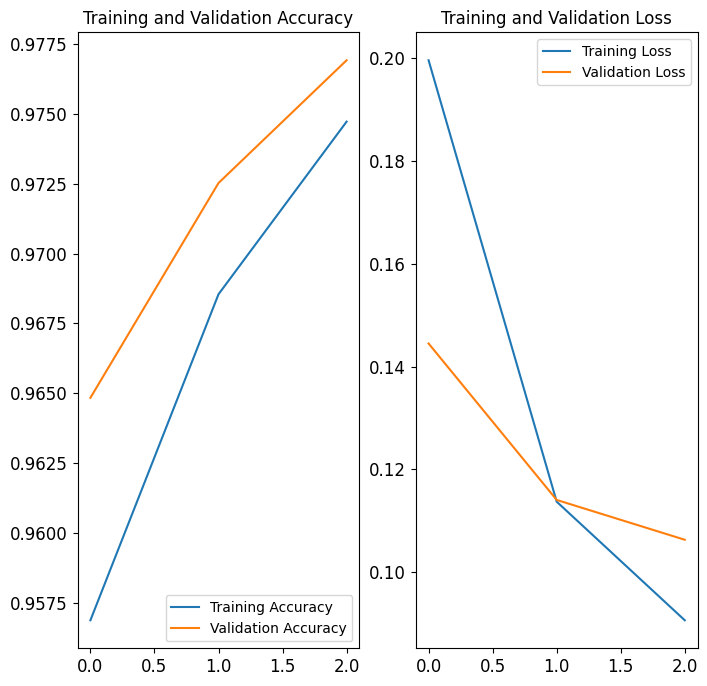

In [73]:
plot_train_val_accuracy(history, epochs)



In [56]:
# Evaluate the model on the test data using `evaluate`
test_ds = get_test_dataset()
eval_res = vg_model.evaluate(test_ds, verbose=2)
eval_res

Found 5126 files belonging to 2 classes.
161/161 - 535s - loss: 0.6078 - accuracy: 0.8137 - 535s/epoch - 3s/step


[0.6077831387519836, 0.8136948943138123]

In [57]:
# Make predictions on the test data
test_ds = get_test_dataset()
predictions = vg_model.predict(test_ds)

Found 5126 files belonging to 2 classes.
161/161 [==============================] - 559s 3s/step


              precision    recall  f1-score   support

      benign       0.96      0.37      0.53      1482
     malware       0.80      0.99      0.88      3644

    accuracy                           0.81      5126
   macro avg       0.88      0.68      0.71      5126
weighted avg       0.84      0.81      0.78      5126



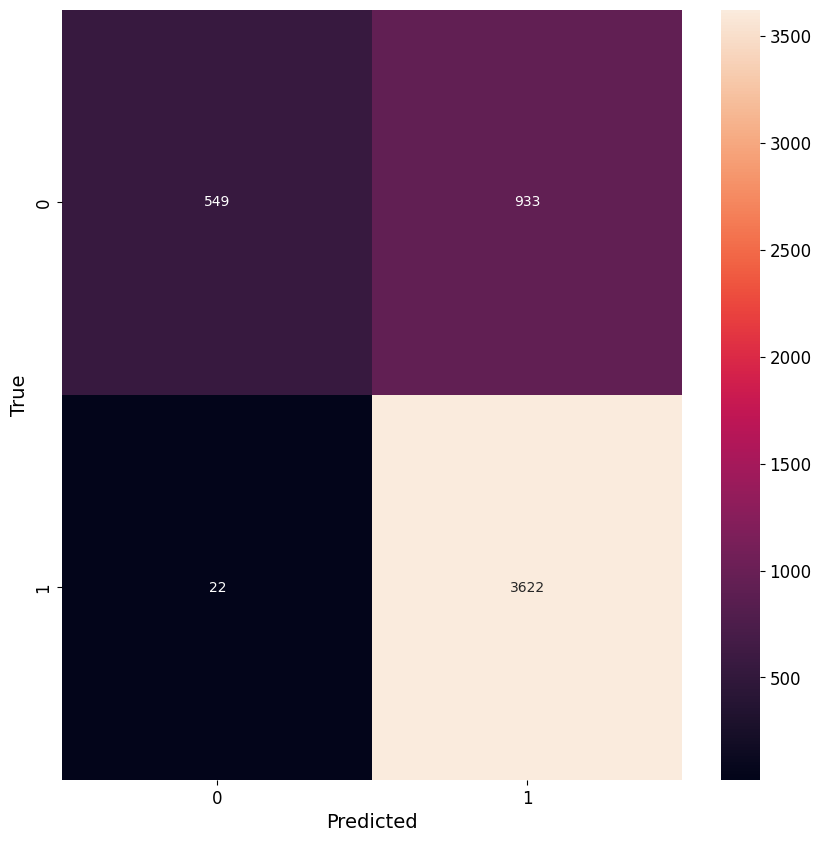

In [76]:
report(predictions, test_ds)